In [1]:
import cv2
import torch
import numpy as np
from IPython.display import display, clear_output
from PIL import Image
import time
import cv2
import numpy as np
from scipy.optimize import linear_sum_assignment
from filterpy.kalman import KalmanFilter
from collections import deque
# Import YOLOv5
#import yolov5

In [2]:
import torch

# Load YOLOv5 model from PyTorch Hub
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

# Set the confidence threshold
model.conf = 0.25

print("YOLOv5 model loaded successfully using PyTorch Hub")


Using cache found in C:\Users\urvas/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2024-9-10 Python-3.12.4 torch-2.4.1+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


YOLOv5 model loaded successfully using PyTorch Hub


In [27]:
class Tracker:
    def __init__(self, max_age=1, min_hits=3, entry_line=0.3, exit_line=0.7):
        self.max_age = max_age
        self.min_hits = min_hits
        self.tracks = []
        self.frame_count = 0
        self.entry_line = entry_line
        self.exit_line = exit_line
        self.vehicles_entered = 0
        self.vehicles_exited = 0
        self.tracked_entries = set()
        self.tracked_exits = set()

    def _get_cost_matrix(self, detections):
        cost_matrix = np.zeros((len(self.tracks), len(detections)))
        for i, track in enumerate(self.tracks):
            for j, detection in enumerate(detections):
                cost_matrix[i, j] = np.linalg.norm(track.predict() - detection[:4])
        return cost_matrix

    def _assignment(self, detections):
        cost_matrix = self._get_cost_matrix(detections)
        row_ind, col_ind = linear_sum_assignment(cost_matrix)
        unmatched_tracks = [t for t in range(len(self.tracks)) if t not in row_ind]
        unmatched_detections = [d for d in range(len(detections)) if d not in col_ind]
        matches = list(zip(row_ind, col_ind))
        return matches, unmatched_tracks, unmatched_detections

    def _check_entry_exit(self, track, frame_height):
        y_center = (track.bbox[1] + track.bbox[3]) / 2 / frame_height
        
        if y_center < self.entry_line and track.id not in self.tracked_entries:
            self.vehicles_entered += 1
            self.tracked_entries.add(track.id)
        
        if y_center > self.exit_line and track.id not in self.tracked_exits:
            self.vehicles_exited += 1
            self.tracked_exits.add(track.id)

    def update(self, detections, frame_height, frame_width):
        self.frame_count += 1
        
        if len(self.tracks) == 0:
            for detection in detections:
                self.tracks.append(Track(detection))
        else:
            matches, unmatched_tracks, unmatched_detections = self._assignment(detections)
            
            for track_idx, detection_idx in matches:
                self.tracks[track_idx].update(detections[detection_idx])
                self._check_entry_exit(self.tracks[track_idx], frame_height)
            
            for track_idx in unmatched_tracks:
                self.tracks[track_idx].mark_missed()
            
            for detection_idx in unmatched_detections:
                new_track = Track(detections[detection_idx])
                self.tracks.append(new_track)
                self._check_entry_exit(new_track, frame_height)

        ret = []
        active_tracks = []
        for track in self.tracks:
            if track.is_confirmed() and track.time_since_update <= self.max_age:
                ret.append(np.concatenate((track.get_state(), [track.id])).reshape(1, -1))
                active_tracks.append(track)
        
        self.tracks = [t for t in self.tracks if t.time_since_update <= self.max_age]
        
        # Calculate vehicle density
        frame_area = frame_height * frame_width
        total_vehicle_area = sum([(t.bbox[2] - t.bbox[0]) * (t.bbox[3] - t.bbox[1]) for t in active_tracks])
        vehicle_density = total_vehicle_area / frame_area

        return np.concatenate(ret) if len(ret) > 0 else np.empty((0, 5)), vehicle_density

    def get_counts(self):
        return self.vehicles_entered, self.vehicles_exited

In [29]:
class Track:
    count = 0
    def __init__(self, initial_detection):
        self.id = Track.count
        Track.count += 1
        self.bbox = initial_detection[:4]
        self.hits = 1
        self.time_since_update = 0
        self.state = initial_detection

    def predict(self):
        return self.state[:4]

    def update(self, detection):
        self.hits += 1
        self.time_since_update = 0
        self.state = detection
        self.bbox = detection[:4]

    def mark_missed(self):
        self.time_since_update += 1

    def is_confirmed(self):
        return self.hits >= 3

    def get_state(self):
        return self.state

In [30]:
class SpeedEstimator:
    def __init__(self, fps=30, pixel_to_meter_ratio=0.1):
        self.fps = fps
        self.pixel_to_meter_ratio = pixel_to_meter_ratio
        self.previous_positions = {}
    
    def estimate(self, tracks):
        speeds = {}
        for track in tracks:
            track_id = int(track[-1])
            current_position = track[:4]
            
            if track_id in self.previous_positions:
                prev_position = self.previous_positions[track_id]
                distance = np.linalg.norm(current_position[:2] - prev_position[:2])
                distance_meters = distance * self.pixel_to_meter_ratio
                time_seconds = 1 / self.fps
                speed = (distance_meters / time_seconds) * 3.6  # Convert to km/h
                speeds[track_id] = speed
            
            self.previous_positions[track_id] = current_position
        
        return speeds

In [31]:
class CongestionDetector:
    def __init__(self, speed_threshold=30, density_threshold=0.15):
        self.speed_threshold = speed_threshold  # km/h
        self.density_threshold = density_threshold
    
    def detect_congestion(self, average_speed, vehicle_density):
        is_congested = average_speed < self.speed_threshold and vehicle_density > self.density_threshold
        congestion_level = self._calculate_congestion_level(average_speed, vehicle_density)
        return is_congested, congestion_level
    
    def _calculate_congestion_level(self, average_speed, vehicle_density):
        speed_factor = max(0, (self.speed_threshold - average_speed) / self.speed_threshold)
        density_factor = max(0, (vehicle_density - self.density_threshold) / (1 - self.density_threshold))
        return (speed_factor + density_factor) / 2  # Returns a value between 0 and 1

In [32]:
class IncidentDetector:
    def __init__(self, stop_time_threshold=3, speed_change_threshold=20):
        self.stop_time_threshold = stop_time_threshold  # seconds
        self.speed_change_threshold = speed_change_threshold  # km/h
        self.vehicle_history = {}
        self.incidents = []

    def update(self, tracks, speeds, frame_count, fps):
        new_incidents = []
        for track in tracks:
            track_id = int(track[-1])
            position = track[:4]
            speed = speeds.get(track_id, 0)
            
            if track_id not in self.vehicle_history:
                self.vehicle_history[track_id] = []
            
            self.vehicle_history[track_id].append((frame_count, position, speed))
            
            # Check for stopped vehicles
            if len(self.vehicle_history[track_id]) >= self.stop_time_threshold * fps:
                recent_history = self.vehicle_history[track_id][-int(self.stop_time_threshold * fps):]
                if all(abs(speed) < 1 for _, _, speed in recent_history):
                    new_incidents.append((track_id, "Stopped Vehicle", position))
            
            # Check for sudden speed changes
            if len(self.vehicle_history[track_id]) >= 2:
                prev_speed = self.vehicle_history[track_id][-2][2]
                if abs(speed - prev_speed) > self.speed_change_threshold:
                    new_incidents.append((track_id, "Sudden Speed Change", position))
        
        self.incidents = new_incidents
        return new_incidents

    def get_incidents(self):
        return self.incidents

In [33]:
def display_frame(frame):
    clear_output(wait=True)
    img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    display(img)

In [34]:
def process_video(video_path, max_frames=None):
    cap = cv2.VideoCapture(video_path)
    tracker = Tracker(entry_line=0.3, exit_line=0.7)
    speed_estimator = SpeedEstimator(fps=cap.get(cv2.CAP_PROP_FPS))
    congestion_detector = CongestionDetector()
    incident_detector = IncidentDetector()  # Add this line
    
    frame_count = 0
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        frame_count += 1
        if max_frames is not None and frame_count > max_frames:
            break
        
        # Perform object detection
        results = model(frame)
        
        # Extract detections (assuming we're only interested in vehicles - class 2 in COCO dataset)
        detections = results.xyxy[0][results.xyxy[0][:, 5] == 2].cpu().numpy()
        
        # Update tracker
        tracks, vehicle_density = tracker.update(detections, frame.shape[0], frame.shape[1])
        
        # Estimate speeds
        speeds = speed_estimator.estimate(tracks)
        
        # Calculate average speed
        average_speed = np.mean(list(speeds.values())) if speeds else 0
        
        # Detect congestion
        is_congested, congestion_level = congestion_detector.detect_congestion(average_speed, vehicle_density)
        
        # Detect incidents
        incidents = incident_detector.update(tracks, speeds, frame_count, cap.get(cv2.CAP_PROP_FPS))
        
        # Draw bounding boxes, speeds, and entry/exit lines on the frame
        cv2.line(frame, (0, int(frame.shape[0] * tracker.entry_line)), (frame.shape[1], int(frame.shape[0] * tracker.entry_line)), (255, 0, 0), 2)
        cv2.line(frame, (0, int(frame.shape[0] * tracker.exit_line)), (frame.shape[1], int(frame.shape[0] * tracker.exit_line)), (0, 0, 255), 2)
        
        for track in tracks:
            bbox = track[:4].astype(int)
            track_id = int(track[-1])
            cv2.rectangle(frame, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)
            speed = speeds.get(track_id, 0)
            cv2.putText(frame, f"ID: {track_id}, Speed: {speed:.2f} km/h", 
                        (bbox[0], bbox[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        
        # Display vehicle counts and traffic information
        entered, exited = tracker.get_counts()
        cv2.putText(frame, f"Entered: {entered}, Exited: {exited}", 
                    (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)
        cv2.putText(frame, f"Avg Speed: {average_speed:.2f} km/h", 
                    (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)
        cv2.putText(frame, f"Density: {vehicle_density:.2f}", 
                    (10, 110), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)
        
        congestion_color = (0, 0, 255) if is_congested else (0, 255, 0)
        cv2.putText(frame, f"Congestion: {'Yes' if is_congested else 'No'}", 
                    (10, 150), cv2.FONT_HERSHEY_SIMPLEX, 1, congestion_color, 2)
        cv2.putText(frame, f"Congestion Level: {congestion_level:.2f}", 
                    (10, 190), cv2.FONT_HERSHEY_SIMPLEX, 1, congestion_color, 2)
        
        # Display incidents
        for i, (track_id, incident_type, position) in enumerate(incidents):
            cv2.putText(frame, f"Incident: {incident_type} (ID: {track_id})", 
                        (10, 230 + i*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
            cv2.circle(frame, (int(position[0]), int(position[1])), 20, (0, 0, 255), 2)
        
        # Display the frame
        display_frame(frame)
        
        # Add a small delay to make the video playback smoother
        time.sleep(0.1)
    
    cap.release()

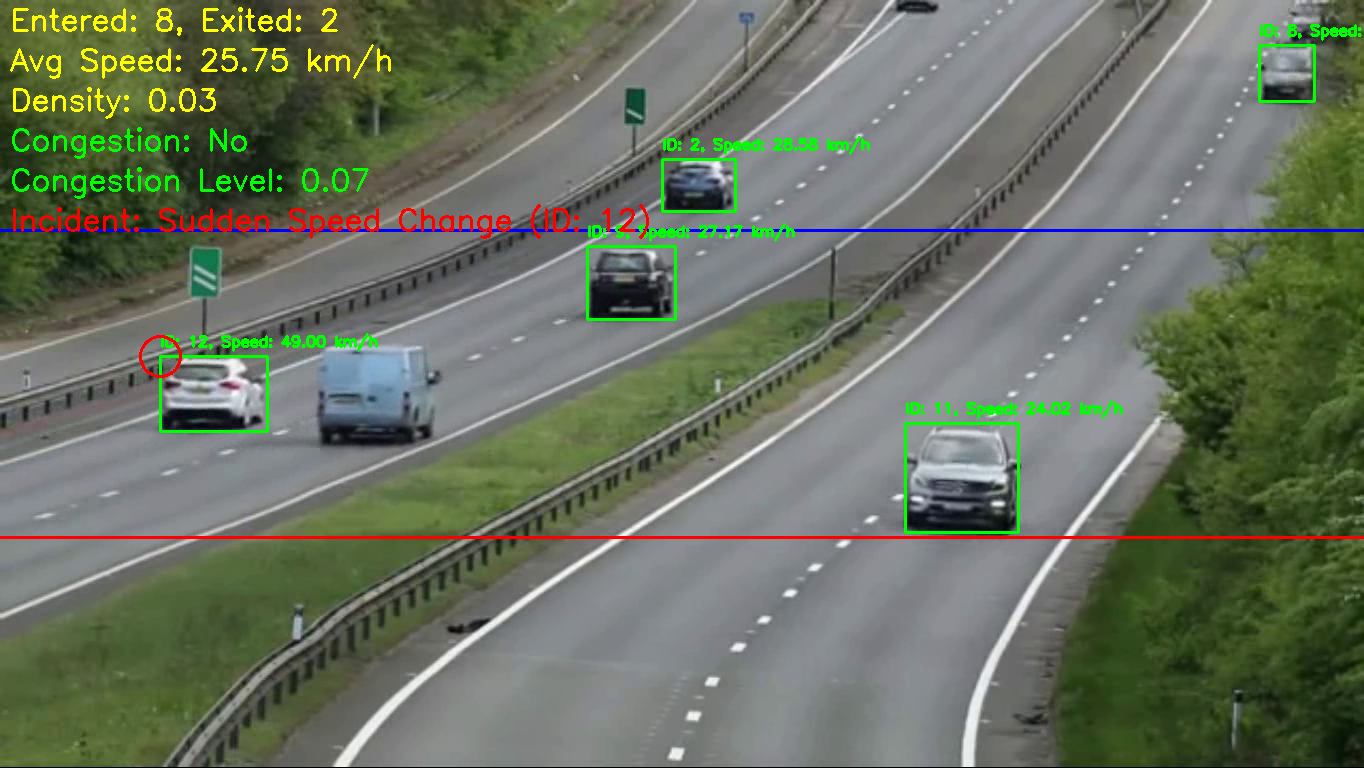

In [35]:
process_video(r'C:\Users\urvas\Downloads\british_highway_traffic (1).mp4', max_frames=100)  # Process first 100 frames

In [2]:
import React from 'react';
import ReactDOM from 'react-dom';
import { LineChart, Line, XAxis, YAxis, CartesianGrid, Tooltip, Legend, ResponsiveContainer } from 'recharts';

// Define a simple dashboard component
const Dashboard = ({ data }) => {
  return (
    <div style={{ fontFamily: 'Arial, sans-serif', padding: '20px' }}>
      <h1 style={{ textAlign: 'center' }}>Traffic Monitoring Dashboard</h1>
      <div style={{ display: 'flex', justifyContent: 'space-around', marginBottom: '20px' }}>
        <div>
          <h3>Vehicle Count</h3>
          <p style={{ fontSize: '24px', fontWeight: 'bold' }}>{data.vehicleCount}</p>
        </div>
        <div>
          <h3>Average Speed</h3>
          <p style={{ fontSize: '24px', fontWeight: 'bold' }}>{data.averageSpeed} km/h</p>
        </div>
        <div>
          <h3>Congestion Level</h3>
          <p style={{ fontSize: '24px', fontWeight: 'bold' }}>{data.congestionLevel}</p>
        </div>
      </div>
      <div style={{ height: '300px' }}>
        <ResponsiveContainer width="100%" height="100%">
          <LineChart data={data.trafficData}>
            <CartesianGrid strokeDasharray="3 3" />
            <XAxis dataKey="time" />
            <YAxis yAxisId="left" />
            <YAxis yAxisId="right" orientation="right" />
            <Tooltip />
            <Legend />
            <Line yAxisId="left" type="monotone" dataKey="vehicleCount" stroke="#8884d8" name="Vehicle Count" />
            <Line yAxisId="right" type="monotone" dataKey="averageSpeed" stroke="#82ca9d" name="Avg Speed (km/h)" />
          </LineChart>
        </ResponsiveContainer>
      </div>
    </div>
  );
};

// Function to render the dashboard
window.renderDashboard = (data, containerId) => {
  ReactDOM.render(<Dashboard data={data} />, document.getElementById(containerId));
};

SyntaxError: invalid syntax (3104527063.py, line 1)

In [ ]:
%%html
<div id="dashboard-container"></div>
<script src="https://unpkg.com/react@17/umd/react.production.min.js"></script>
<script src="https://unpkg.com/react-dom@17/umd/react-dom.production.min.js"></script>
<script src="path/to/your/bundled/dashboard.js"></script>

In [ ]:
from IPython.display import display, HTML
import json

def update_dashboard(data):
    js_code = f"""
    <script>
    renderDashboard({json.dumps(data)}, 'dashboard-container');
    </script>
    """
    display(HTML(js_code))

In [ ]:
import cv2
# ... (your existing imports)

def process_video(video_path, max_frames=None):
    cap = cv2.VideoCapture(video_path)
    tracker = Tracker(entry_line=0.3, exit_line=0.7)
    speed_estimator = SpeedEstimator(fps=cap.get(cv2.CAP_PROP_FPS))
    congestion_detector = CongestionDetector()
    incident_detector = LessSensitiveIncidentDetector()
    
    frame_count = 0
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        frame_count += 1
        if max_frames is not None and frame_count > max_frames:
            break
        
        # Your existing video processing code here
        # ...

        # Prepare data for dashboard
        dashboard_data = {
            "vehicleCount": len(tracks),
            "averageSpeed": average_speed,
            "congestionLevel": congestion_level,
            "trafficData": [
                {"time": frame_count, "vehicleCount": len(tracks), "averageSpeed": average_speed}
            ]
        }

        # Update dashboard every 30 frames (adjust as needed)
        if frame_count % 30 == 0:
            update_dashboard(dashboard_data)

    cap.release()

